# Building ELMo: From LSTMs to Bidirectional Stacked LSTMs

## Introduction

In this notebook, we'll build **ELMo (Embeddings from Language Models)** step by step. ELMo is a deep contextualized word representation that models:
- Complex characteristics of word use (e.g., syntax and semantics)
- How these uses vary across linguistic contexts (polysemy)

### Learning Path:
1. **Basic LSTM** - Understanding the core building block
2. **Stacked LSTM** - Adding depth to capture hierarchical features
3. **Bidirectional LSTM** - Capturing context from both directions
4. **ELMo** - Combining everything with character-level embeddings

Let's begin!

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Load and Prepare Data

We'll use the twitter subset for sentiment analysis. This will help us test each architecture.

In [14]:
# Load the twitter subset
df = pd.read_csv('data/twitter.csv')
# shuffle df and sample a balanced dataset with 4000 samples
df = df.sample(frac=1).reset_index(drop=True)
df = df.groupby('sentiment').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())

Dataset shape: (6000, 2)

First few rows:
                                                text  sentiment
0  woohoo india can now shoot down satellites mus...       -1.0
1  have fallen from the ‘superpower’ status since...       -1.0
2  honestly feel this point rahul totally wrong s...       -1.0
3  lolzthis tweet made daysir plz start training ...       -1.0
4  acb raids bjp other peoples its law raids then...       -1.0

Sentiment distribution:
sentiment
-1.0    2000
 0.0    2000
 1.0    2000
Name: count, dtype: int64


In [15]:
# Simple text preprocessing
import re

# Preprocessing functions
def preprocess_text(text):
    """Basic text preprocessing"""
    text = str(text).lower() # Ensure string
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    # remove @
    text = re.sub(r'@\w+', '', text)
    # remove links
    text = re.sub(r'http:\/\/[\w.\/]+', '', text)
    # remove hashtags
    text = re.sub(r'#\w+', '', text)
    return text.split()

# Preprocess all texts
df['tokens'] = df['text'].apply(preprocess_text)
df['label'] = (df['sentiment'] == 'positive').astype(int)

print("Sample preprocessed text:")
print(f"Original: {df['text'].iloc[0][:200]}...")
print(f"Tokens: {df['tokens'].iloc[0][:20]}...")
print(f"Label: {df['label'].iloc[0]}")

Sample preprocessed text:
Original: woohoo india can now shoot down satellites must vote for modi now farmers and young people all over india...
Tokens: ['woohoo', 'india', 'can', 'now', 'shoot', 'down', 'satellites', 'must', 'vote', 'for', 'modi', 'now', 'farmers', 'and', 'young', 'people', 'all', 'over', 'india']...
Label: 0


In [16]:
# Build vocabulary
def build_vocab(tokenized_texts, min_freq=2):
    """Build vocabulary from tokenized texts"""
    counter = Counter()
    for tokens in tokenized_texts:
        counter.update(tokens)
    
    # Special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}
    
    # Add words that appear at least min_freq times
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab

vocab = build_vocab(df['tokens'])
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample words: {list(vocab.items())[:10]}")

Vocabulary size: 6405
Sample words: [('<PAD>', 0), ('<UNK>', 1), ('india', 2), ('can', 3), ('now', 4), ('shoot', 5), ('down', 6), ('satellites', 7), ('must', 8), ('vote', 9)]


In [17]:
# Dataset class
class TwitterDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=200):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = self.texts[idx]
        label = self.labels[idx]
        
        # Convert tokens to indices
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        
        # Truncate or pad
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices = indices + [self.vocab['<PAD>']] * (self.max_len - len(indices))
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Split data
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

# Create datasets
train_dataset = TwitterDataset(train_df['tokens'].tolist(), train_df['label'].tolist(), vocab)
test_dataset = TwitterDataset(test_df['tokens'].tolist(), test_df['label'].tolist(), vocab)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 4800
Test samples: 1200
Batches per epoch: 150


## Part 1: Basic LSTM

### What is an LSTM?

LSTM (Long Short-Term Memory) is a type of RNN that can learn long-term dependencies. It solves the vanishing gradient problem using:

1. **Cell State (C_t)**: The "memory" that flows through the network
2. **Hidden State (h_t)**: The output at each time step
3. **Three Gates**:
   - **Forget Gate (f_t)**: Decides what to forget from cell state
   - **Input Gate (i_t)**: Decides what new information to store
   - **Output Gate (o_t)**: Decides what to output

### LSTM Equations:

```
f_t = σ(W_f · [h_{t-1}, x_t] + b_f)          # Forget gate
i_t = σ(W_i · [h_{t-1}, x_t] + b_i)          # Input gate
C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)      # Candidate cell state
C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t             # New cell state
o_t = σ(W_o · [h_{t-1}, x_t] + b_o)          # Output gate
h_t = o_t ⊙ tanh(C_t)                        # New hidden state
```

Where:
- σ is the sigmoid function
- ⊙ is element-wise multiplication
- tanh is the hyperbolic tangent function

In [18]:
class BasicLSTM(nn.Module):
    """
    Basic LSTM for sentiment classification.
    
    Architecture:
    1. Embedding layer: Converts word indices to dense vectors
    2. LSTM layer: Processes the sequence
    3. Fully connected layer: Maps LSTM output to class probabilities
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(BasicLSTM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Single LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len)
        
        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        # x shape: (batch_size, seq_len)
        
        # Embedding: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)
        
        # LSTM: output shape (batch_size, seq_len, hidden_dim)
        # hidden shape (1, batch_size, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use the last hidden state
        # hidden shape: (1, batch_size, hidden_dim) -> (batch_size, hidden_dim)
        hidden = hidden.squeeze(0)
        
        # Apply dropout
        hidden = self.dropout(hidden)
        
        # Fully connected: (batch_size, output_dim)
        output = self.fc(hidden)
        
        return output

# Initialize model
basic_lstm = BasicLSTM(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=3,
    dropout=0.5
).to(device)

print("Basic LSTM Architecture:")
print(basic_lstm)
print(f"\nTotal parameters: {sum(p.numel() for p in basic_lstm.parameters())}")

Basic LSTM Architecture:
BasicLSTM(
  (embedding): Embedding(6405, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

Total parameters: 758647


In [19]:
# Training and evaluation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(dataloader), correct / total

def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    """Complete training loop"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    return history

def plot_history(history, title):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['test_loss'], label='Test Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['test_acc'], label='Test Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

Training Basic LSTM...

Epoch 1/2


Evaluating: 100%|██████████| 38/38 [00:00<00:00, 51.64it/s]


Train Loss: 0.0779, Train Acc: 0.9998
Test Loss: 0.0001, Test Acc: 1.0000

Epoch 2/2


Evaluating: 100%|██████████| 38/38 [00:00<00:00, 46.04it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Test Loss: 0.0000, Test Acc: 1.0000


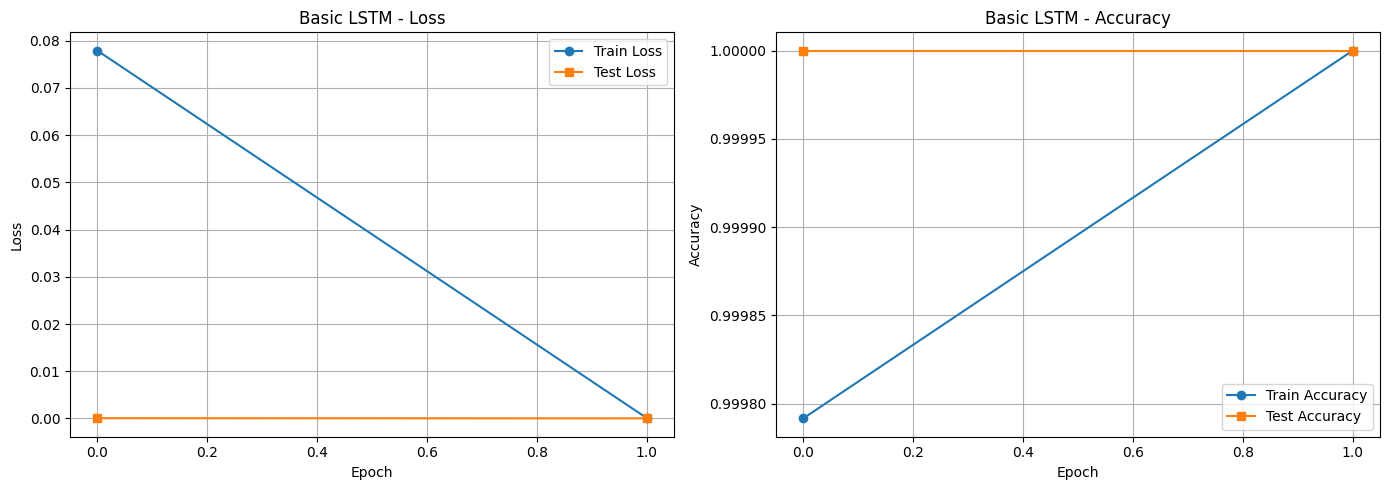

In [20]:
# Train Basic LSTM
print("Training Basic LSTM...")
basic_lstm_history = train_model(basic_lstm, train_loader, test_loader, epochs=2, lr=0.001)
plot_history(basic_lstm_history, "Basic LSTM")

## Part 2: Stacked LSTM

### Why Stack LSTMs?

Stacking multiple LSTM layers allows the model to learn **hierarchical representations**:

1. **Lower layers** learn low-level patterns (e.g., syntax, simple phrases)
2. **Higher layers** learn high-level patterns (e.g., semantics, complex relationships)

### Architecture:
```
Input → Embedding → LSTM Layer 1 → LSTM Layer 2 → ... → LSTM Layer N → Output
```

Each LSTM layer takes the output sequence from the previous layer as input.

### Key Points:
- **Depth vs Width**: Stacking adds depth (more layers), not width (larger hidden size)
- **Dropout**: Applied between layers to prevent overfitting
- **Computational Cost**: Increases with number of layers

In [21]:
class StackedLSTM(nn.Module):
    """
    Stacked LSTM with multiple layers.
    
    Architecture:
    1. Embedding layer
    2. Multiple stacked LSTM layers
    3. Fully connected layer
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 num_layers=2, dropout=0.5):
        super(StackedLSTM, self).__init__()
        
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Stacked LSTM layers
        # num_layers parameter creates multiple LSTM layers
        # dropout is applied between LSTM layers (not after the last one)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # Dropout between layers
        )
        
        # Dropout after LSTM
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len)
        
        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        # Embedding: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)
        
        # Stacked LSTM
        # output: (batch_size, seq_len, hidden_dim)
        # hidden: (num_layers, batch_size, hidden_dim)
        # cell: (num_layers, batch_size, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use the last layer's hidden state
        # hidden[-1] shape: (batch_size, hidden_dim)
        hidden = hidden[-1]
        
        # Apply dropout
        hidden = self.dropout(hidden)
        
        # Fully connected: (batch_size, output_dim)
        output = self.fc(hidden)
        
        return output

# Initialize model with 2 layers
stacked_lstm = StackedLSTM(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=3,
    num_layers=2,  # Stack 2 LSTM layers
    dropout=0.5
).to(device)

print("Stacked LSTM Architecture:")
print(stacked_lstm)
print(f"\nTotal parameters: {sum(p.numel() for p in stacked_lstm.parameters())}")
print(f"\nNote: This has more parameters than Basic LSTM due to additional layers")

Stacked LSTM Architecture:
StackedLSTM(
  (embedding): Embedding(6405, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

Total parameters: 890743

Note: This has more parameters than Basic LSTM due to additional layers


Training Stacked LSTM...

Epoch 1/2


Evaluating: 100%|██████████| 38/38 [00:01<00:00, 26.38it/s]


Train Loss: 0.0684, Train Acc: 0.9785
Test Loss: 0.0001, Test Acc: 1.0000

Epoch 2/2


Evaluating: 100%|██████████| 38/38 [00:01<00:00, 25.98it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Test Loss: 0.0000, Test Acc: 1.0000


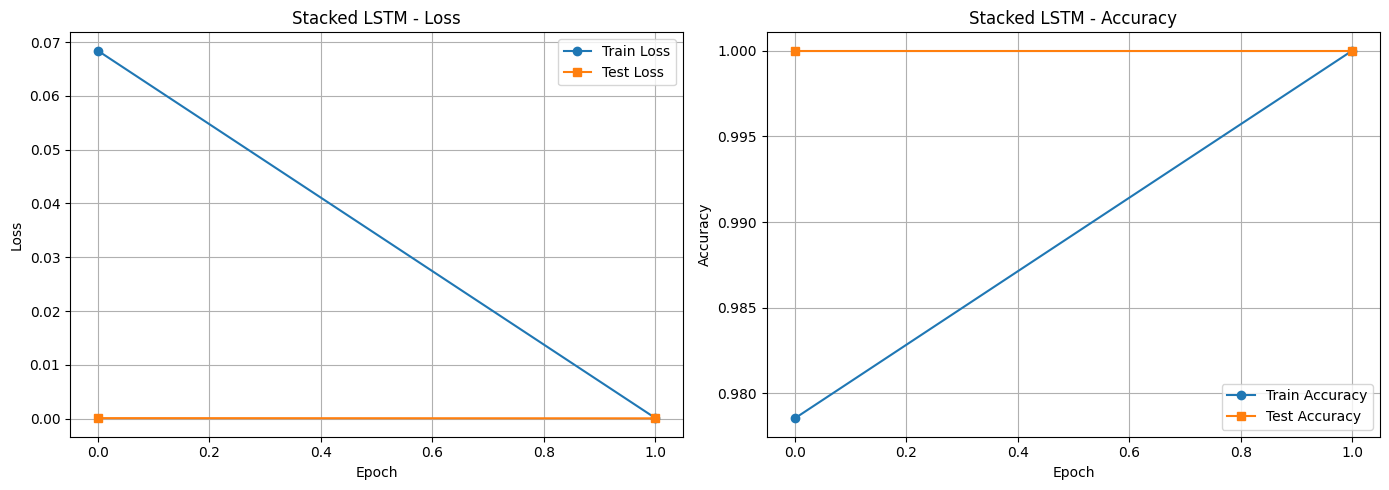

In [22]:
# Train Stacked LSTM
print("Training Stacked LSTM...")
stacked_lstm_history = train_model(stacked_lstm, train_loader, test_loader, epochs=2, lr=0.001)
plot_history(stacked_lstm_history, "Stacked LSTM")

## Part 3: Bidirectional LSTM

### Why Bidirectional?

Standard LSTMs process sequences in one direction (left-to-right). However, in many NLP tasks, **context from both directions** is important.

**Example**: "The movie was not good"
- Forward LSTM at "not": sees "The movie was"
- Backward LSTM at "not": sees "good"
- Combined: understands the negation better!

### Architecture:
```
Forward LSTM:  → → → → →
Input:         x₁ x₂ x₃ x₄ x₅
Backward LSTM: ← ← ← ← ←
```

At each time step, we concatenate the forward and backward hidden states:
```
h_t = [h_forward_t ; h_backward_t]
```

### Key Points:
- **Double the hidden size**: Output dimension is 2 × hidden_dim
- **Better context**: Sees both past and future
- **Not suitable for**: Real-time prediction (needs full sequence)

In [23]:
class BidirectionalLSTM(nn.Module):
    """
    Bidirectional LSTM that processes sequences in both directions.
    
    Architecture:
    1. Embedding layer
    2. Bidirectional LSTM (forward + backward)
    3. Fully connected layer (input size is 2 × hidden_dim)
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(BidirectionalLSTM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            batch_first=True,
            bidirectional=True  # This makes it bidirectional!
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        # Input size is 2 × hidden_dim because we concatenate forward and backward
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len)
        
        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        # Embedding: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)
        
        # Bidirectional LSTM
        # output: (batch_size, seq_len, hidden_dim * 2)
        # hidden: (2, batch_size, hidden_dim)  # 2 for forward and backward
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Concatenate the final forward and backward hidden states
        # hidden[0]: forward LSTM's last hidden state
        # hidden[1]: backward LSTM's last hidden state
        # Shape: (batch_size, hidden_dim * 2)
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        
        # Apply dropout
        hidden = self.dropout(hidden)
        
        # Fully connected: (batch_size, output_dim)
        output = self.fc(hidden)
        
        return output

# Initialize model
bidirectional_lstm = BidirectionalLSTM(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=3,
    dropout=0.5
).to(device)

print("Bidirectional LSTM Architecture:")
print(bidirectional_lstm)
print(f"\nTotal parameters: {sum(p.numel() for p in bidirectional_lstm.parameters())}")
print(f"\nNote: More parameters than Basic LSTM due to backward LSTM")

Bidirectional LSTM Architecture:
BidirectionalLSTM(
  (embedding): Embedding(6405, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

Total parameters: 876791

Note: More parameters than Basic LSTM due to backward LSTM


Training Bidirectional LSTM...

Epoch 1/2


Evaluating: 100%|██████████| 38/38 [00:01<00:00, 23.85it/s]


Train Loss: 0.0787, Train Acc: 0.9852
Test Loss: 0.0000, Test Acc: 1.0000

Epoch 2/2


Evaluating: 100%|██████████| 38/38 [00:01<00:00, 24.35it/s]


Train Loss: 0.0000, Train Acc: 1.0000
Test Loss: 0.0000, Test Acc: 1.0000


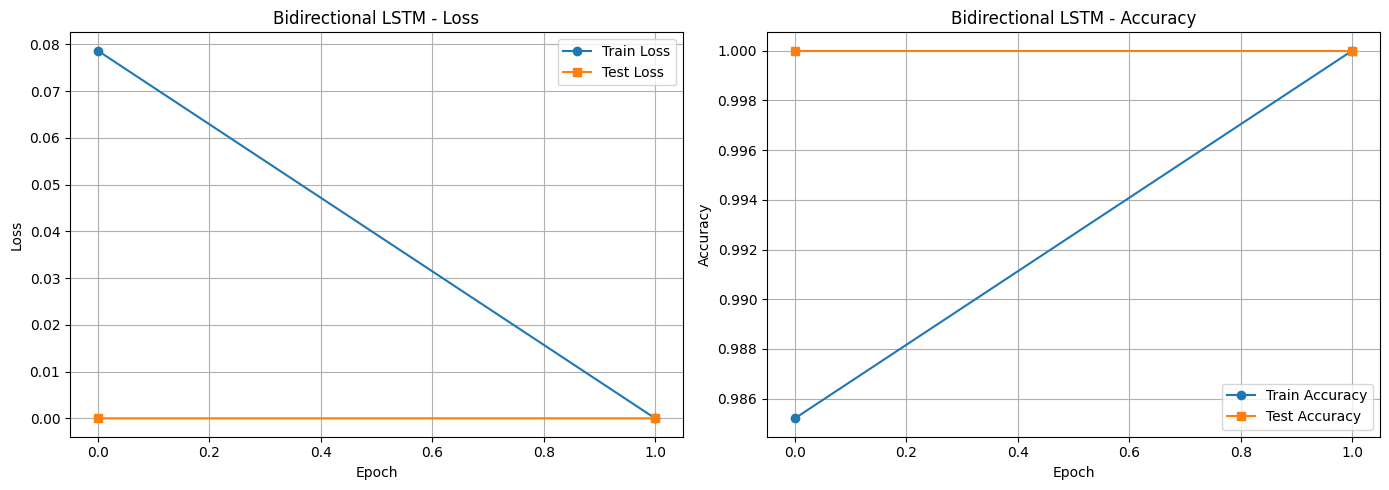

In [24]:
# Train Bidirectional LSTM
print("Training Bidirectional LSTM...")
bidirectional_lstm_history = train_model(bidirectional_lstm, train_loader, test_loader, epochs=2, lr=0.001)
plot_history(bidirectional_lstm_history, "Bidirectional LSTM")

## Part 4: ELMo (Embeddings from Language Models)

### What is ELMo?

ELMo (Peters et al., 2018) creates **contextualized word embeddings** using a deep bidirectional language model.





Epoch 1/2


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 38/38 [00:04<00:00,  7.84it/s]


Train Loss: 0.0704, Train Acc: 0.9940
Test Loss: 0.0002, Test Acc: 1.0000

Epoch 2/2


Evaluating: 100%|██████████| 38/38 [00:04<00:00,  7.81it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Test Loss: 0.0001, Test Acc: 1.0000


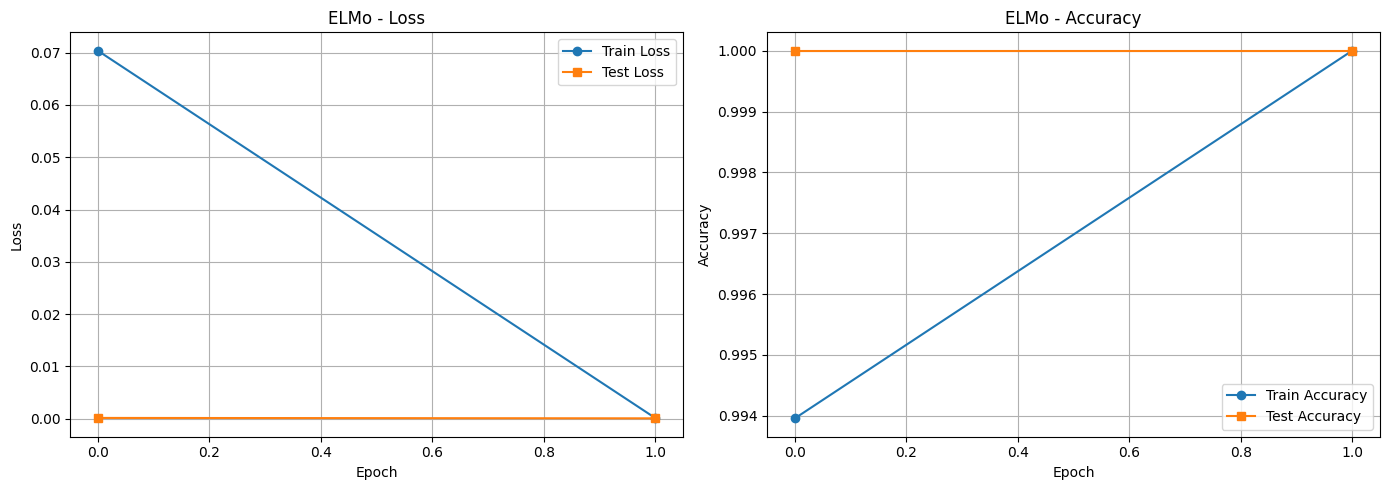

In [26]:



# ELMo Model (Bidirectional Stacked LSTM with Scalar Mixing)
class ELMo(nn.Module):
    """
    ELMo-style model for sentiment analysis.
    Uses a weighted sum of layers from a stacked bidirectional LSTM.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.5):
        super(ELMo, self).__init__()
        
        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Projection for embedding layer to match LSTM output dimension if needed
        self.embedding_projection = nn.Linear(embedding_dim, hidden_dim * 2) 
        
        # 2. Stacked Bidirectional LSTM Layers
        # We use ModuleList to access intermediate outputs
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(
                input_size=hidden_dim * 2 if i > 0 else embedding_dim,
                hidden_size=hidden_dim,
                batch_first=True,
                bidirectional=True
            )
            for i in range(n_layers)
        ])
        
        # 3. Scalar Mixing Parameters
        # Weights for each layer (0=embedding, 1..n=LSTMs)
        self.layer_weights = nn.Parameter(torch.randn(n_layers + 1))
        self.gamma = nn.Parameter(torch.ones(1))
        
        # 4. Classifier
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text):
        # text: (batch_size, seq_len)
        
        # Get embeddings
        embedded = self.embedding(text) # (batch, seq, emb_dim)
        
        # Store layer outputs for mixing
        # Layer 0: Projected embedding
        layer_outputs = [self.embedding_projection(embedded)]
        
        # Pass through LSTM layers
        x = embedded
        for lstm in self.lstm_layers:
            # x: (batch, seq, input_size)
            x, _ = lstm(x) # x: (batch, seq, hidden_dim * 2)
            layer_outputs.append(x)
            
        # Stack all layers: (batch, seq, hidden*2, n_layers+1)
        stacked_outputs = torch.stack(layer_outputs, dim=-1)
        
        # Compute normalized weights
        weights = torch.softmax(self.layer_weights, dim=0)
        
        # Weighted sum (ELMo representation): (batch, seq, hidden*2)
        # sum over last dim
        elmo_representation = self.gamma * torch.sum(stacked_outputs * weights, dim=-1)
        
        # Pooling for classification (Mean Pooling over sequence)
        # (batch, hidden*2)
        pooled = torch.mean(elmo_representation, dim=1)
        
        # Classification
        pooled = self.dropout(pooled)
        output = self.fc(pooled)
        
        return output



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize ELMo model
elmo_model = ELMo(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=2,
    dropout=0.5
).to(device)

elmo_history = train_model(elmo_model, train_loader, test_loader, epochs=2, lr=0.001)
plot_history(elmo_history, "ELMo")
